In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyteomics.mzml import MzML
from pyascore import SpectraParser, MassCorrector, PyAscore

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Comparison of pyAscore's performance against PTMProphet

## 1) Intro

Since the original publication of the Ascore algorithm, several modern localization algorithms have been published which are designed especially to handle orbitrap high resolution data. Often, when Ascore was compared head to head with these tools, the parameter choices were taken from the original Ascore paper. Here, we will test pyAscore against PTMProphet, which is a state of the art PTM localization algorithm, and we will see affects the former's performance.

In order to give a fair evaluation to PTMProphet, we will not be incorporating the tool into our previous pipeline for synthetic peptides. PTMProphet works best when used in conjunction with the Trans Proteomic Pipeline to first filter PSMs before scoring. Given, that we will take data straight from Shteynberg *et al.* (2019), and substitute pyAscore at the localization step, so that the differences from the original paper are minimized.

## 2) Load PTMProphet PSM data

Here we will look at dataset \#1 from PTMProphet's original paper. This has lower numbers of PSMs than other datasets within the paper, but all the data was taken on Thermo instruments, which means that creating a map between the PSMs and the original spectra should be rather straight forward

In [2]:
ptmprophet_results = pd.read_csv("../TPP/ptmprophet_PXD007058_results.csv")
select = np.logical_and(ptmprophet_results["peptide_sequence_exists"].astype(bool),
                        ptmprophet_results["precursor_match"].astype(bool))
ptmprophet_results = ptmprophet_results[select]
ptmprophet_results = ptmprophet_results[ptmprophet_results["answer_peptide"].str.count("[STY]\[") == 1]
ptmprophet_results = ptmprophet_results.sort_values("info", ascending=False)

In [3]:
ptmprophet_results["N"] = np.arange(1, ptmprophet_results.shape[0] + 1)
ptmprophet_results["proportion"] = ptmprophet_results["N"]/ptmprophet_results.shape[0]
ptmprophet_results["FLR"] = np.cumsum(1 - ptmprophet_results["peptidoform_matches"])/ptmprophet_results["N"]

In [4]:
for i in reversed(range(ptmprophet_results.shape[0] - 1)):
    ptmprophet_results["FLR"].values[i] = min(ptmprophet_results["FLR"].values[i],
                                              ptmprophet_results["FLR"].values[i+1])

## 3) Compare pyAscore and PTMProphet

### 3.1) Run pyAscore in wide and narrow mode on spectra

In [5]:
corrector = MassCorrector()
def transform_sequence(seq):
    stripped_sequence = re.sub("[^A-Z]", "", seq)
    tokenized_seq = re.findall("[A-Z][^A-Z]*", seq)
    
    # Fix masses
    mod_pos = []
    mod_mass = []
    for pos, aa in enumerate(tokenized_seq, 1):
        mass_search = re.search("[0-9]+", aa)
        if mass_search is not None:
            mod_pos.append(pos)
            mod_mass.append(float(mass_search.group()))
    mod_pos, mod_mass = corrector.correct_multiple(stripped_sequence,
                                                   mod_pos, mod_mass)
    # Get info
    phos_select = np.isclose(mod_mass, 79.966331)
    nphos = np.sum(phos_select)
    aux_mod_pos = mod_pos[~phos_select].astype(np.uint32)
    aux_mod_mass = mod_mass[~phos_select].astype(np.float32)

    result = {"peptide" : stripped_sequence,
              "nphos" : nphos,
              "aux_mod_pos" : np.array(aux_mod_pos, dtype=np.uint32),
              "aux_mod_mass" : np.array(aux_mod_mass, dtype=np.float32)}
    
    return result

In [6]:
def check_sequences(seq1, seq2):
    # Fix 1
    seq1 = seq1.str.replace("(?<=[^STY])\[[0-9]+\]", "", regex=True)
    seq1 = seq1.str.replace("(?<=[STY])\[[0-9]+\]", "*", regex=True)
    
    # Fix 2
    seq2 = seq2.str.replace("(?<=[^STY])\[[0-9]+\]", "", regex=True)
    seq2 = seq2.str.replace("(?<=[STY])\[[0-9]+\]", "*", regex=True)
    
    return seq1 == seq2

In [7]:
ascore_results = ptmprophet_results.loc[:, ["USI"]]
ascore_results = pd.concat(
                     [ascore_results, ascore_results["USI"].str.split(":", expand=True).iloc[:, [2, 4, 5]]],
                     axis=1
                 )
ascore_results.columns = ["USI", "sample", "scan", "sequence"]
ascore_results["scan"] = ascore_results["scan"].astype(int)
ascore_results["charge"] = ascore_results["sequence"].str.replace(".*/", "", regex=True).astype(int)
ascore_results["sequence"] = ascore_results["sequence"].str.replace("/.*", "", regex=True)

In [8]:
spectra = {}
for sample in ascore_results["sample"].unique():
    file_path = "../TPP/" + sample + ".mzML"
    mzml_reader = MzML(file_path)
    spectra[sample] = {
        spectra["index"] + 1 : {"mz_values" : spectra.get("m/z array", np.array([])),
                                "intensity_values" : spectra.get("intensity array", np.array([]))}
        for spectra in mzml_reader
    }

In [48]:
# Initialize pyAscore object
mod_mass = 79.966331
ascore = PyAscore(bin_size=100., n_top=10,
                  mod_group="STY",
                  mod_mass=mod_mass,
                  mz_error=.02)

ascore_narrow_results = ascore_results.copy()
ascore_narrow_results["ascoreSequence"] = ""
ascore_narrow_results["ascore"] = 0.
for ind in range(ascore_narrow_results.shape[0]):
    psm = ascore_narrow_results.iloc[ind]
    spectrum = spectra[psm["sample"]][psm["scan"]]
    peptide_info = transform_sequence(psm["sequence"])
    
    ascore.score(mz_arr = spectrum["mz_values"],
                 int_arr = spectrum["intensity_values"],
                 peptide = peptide_info["peptide"],
                 n_of_mod = peptide_info["nphos"],
                 max_fragment_charge = psm["charge"] - 1,
                 aux_mod_pos = peptide_info["aux_mod_pos"],
                 aux_mod_mass = peptide_info["aux_mod_mass"])
    
    ascore_narrow_results["ascoreSequence"].values[ind] = ascore.best_sequence
    ascore_narrow_results["ascore"].values[ind] = ascore.ascores[0]

/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on E at position 1 with mass: -18.04258999999999 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on W at position 3 with mass: 15.920690000000008 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on W at position 10 with mass: 15.920690000000008 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: 

In [49]:
ascore_narrow_results = ascore_narrow_results.join(ptmprophet_results.loc[:, ["USI", "answer_peptide"]]\
                                                                     .set_index("USI"),
                                                   on="USI")\
                                             .sort_values("ascore", ascending=False)
ascore_narrow_results["match"] = check_sequences(ascore_narrow_results.ascoreSequence, 
                                                 ascore_narrow_results.answer_peptide)

ascore_narrow_results["N"] = np.arange(1, ascore_narrow_results.shape[0] + 1)
ascore_narrow_results["proportion"] = ascore_narrow_results["N"]/ascore_narrow_results.shape[0]
ascore_narrow_results["FLR"] = np.cumsum(~ascore_narrow_results["match"])/ascore_narrow_results["N"]
for i in reversed(range(ascore_narrow_results.shape[0] - 1)):
    ascore_narrow_results["FLR"].values[i] = min(ascore_narrow_results["FLR"].values[i],
                                                 ascore_narrow_results["FLR"].values[i+1])

In [50]:
# Initialize pyAscore object
mod_mass = 79.966331
ascore = PyAscore(bin_size=100., n_top=10,
                  mod_group="STY",
                  mod_mass=mod_mass,
                  mz_error=.5)

ascore_wide_results = ascore_results.copy()
ascore_wide_results["ascoreSequence"] = ""
ascore_wide_results["ascore"] = 0.
for ind in range(ascore_wide_results.shape[0]):
    psm = ascore_wide_results.iloc[ind]
    spectrum = spectra[psm["sample"]][psm["scan"]]
    peptide_info = transform_sequence(psm["sequence"])
    
    ascore.score(mz_arr = spectrum["mz_values"],
                 int_arr = spectrum["intensity_values"],
                 peptide = peptide_info["peptide"],
                 n_of_mod = peptide_info["nphos"],
                 max_fragment_charge = psm["charge"] - 1,
                 aux_mod_pos = peptide_info["aux_mod_pos"],
                 aux_mod_mass = peptide_info["aux_mod_mass"])
    
    ascore_wide_results["ascoreSequence"].values[ind] = ascore.best_sequence
    ascore_wide_results["ascore"].values[ind] = ascore.ascores[0]

/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on E at position 1 with mass: -18.04258999999999 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on W at position 3 with mass: 15.920690000000008 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: UserWarning: Unrecognized mod on W at position 10 with mass: 15.920690000000008 Using uncorrected mass.
  warnings.warn("Unrecognized mod on {} at position {} with mass: {}"
/net/villen/vol2/users/valenta4/miniconda3/envs/pyascore/lib/python3.8/site-packages/pyascore/parsing/id_parsers.py:99: 

In [51]:
ascore_wide_results = ascore_wide_results.join(ptmprophet_results.loc[:, ["USI", "answer_peptide"]]\
                                                                     .set_index("USI"),
                                                   on="USI")\
                                               .sort_values("ascore", ascending=False)
ascore_wide_results["match"] = check_sequences(ascore_wide_results.ascoreSequence, 
                                               ascore_wide_results.answer_peptide)

ascore_wide_results["N"] = np.arange(1, ascore_wide_results.shape[0] + 1)
ascore_wide_results["proportion"] = ascore_wide_results["N"]/ascore_wide_results.shape[0]
ascore_wide_results["FLR"] = np.cumsum(~ascore_wide_results["match"])/ascore_wide_results["N"]
for i in reversed(range(ascore_wide_results.shape[0] - 1)):
    ascore_wide_results["FLR"].values[i] = min(ascore_wide_results["FLR"].values[i],
                                               ascore_wide_results["FLR"].values[i+1])

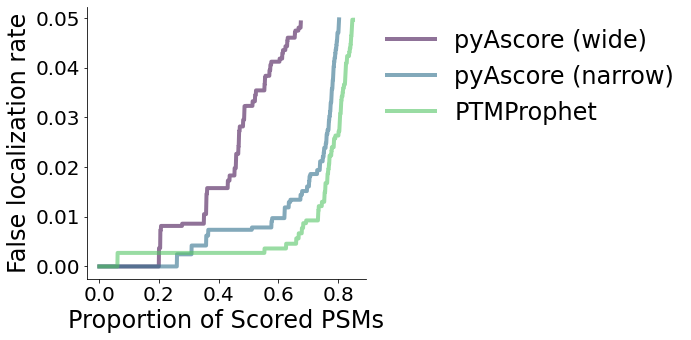

In [78]:
plt.figure(figsize=[5, 5])

sns.lineplot(x="proportion", y="FLR",
             data=ascore_wide_results[ascore_wide_results.FLR < 0.05],
             lw=4,
             color="#461554",
             alpha=.6,
             label="pyAscore (wide)")

sns.lineplot(x="proportion", y="FLR",
             data=ascore_narrow_results[ascore_narrow_results.FLR < 0.05],
             lw=4,
             color="#30708d",
             alpha=.6,
             label="pyAscore (narrow)")

sns.lineplot(x="proportion", y="FLR",
             data=ptmprophet_results[ptmprophet_results.FLR < 0.05],
             lw=4,
             color="#56c566",
             alpha=.6,
             label="PTMProphet")

plt.xticks([0, .2, .4, .6, .8])
plt.yticks([0, .01, .02, .03, .04, .05])
plt.xlabel("Proportion of Scored PSMs", size=24)
plt.ylabel("False localization rate", size=24)
plt.tick_params(labelsize=20)
plt.legend(fontsize=24,
           frameon=False,
           bbox_to_anchor=(1, 1))

sns.despine()
plt.savefig("figures/pyascore_ptmprophet_comparison.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

In [79]:
correct_count = []
for cutoff in [.01, .02, .03, .04, .05]:
    correct_count.append(
        {"cutoff" : cutoff,
         "pyAscore (wide)" : ascore_wide_results[ascore_wide_results.FLR < cutoff].shape[0],
         "pyAscore (narrow)" : ascore_narrow_results[ascore_narrow_results.FLR < cutoff].shape[0],
         "PTMProphet" : ptmprophet_results[ptmprophet_results.FLR < cutoff].shape[0]}
    )

correct_count = pd.DataFrame.from_records(correct_count)
correct_count

,cutoff,pyAscore (wide),pyAscore (narrow),PTMProphet
0,0.01,465,823,972
1,0.02,607,980,1020
2,0.03,644,1022,1070
3,0.04,760,1041,1095
4,0.05,896,1066,1128


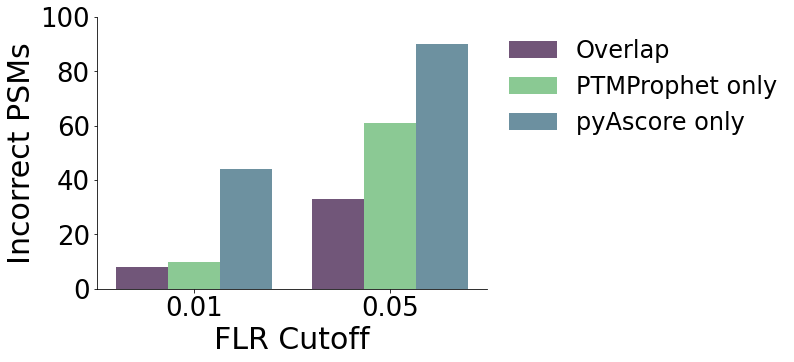

In [85]:
joined_matches = ptmprophet_results.set_index("USI")\
                                   .loc[:, ["peptidoform_matches", "FLR"]]\
                                   .rename({"peptidoform_matches": "match"},
                                           axis=1)\
                                   .astype({"match": bool})\
                                   .join(ascore_narrow_results.set_index("USI").loc[:, ["match", "FLR"]],
                                         lsuffix="_ptmprophet", rsuffix="_pyascore")

error_overlap = []
for cutoff in [0.01, 0.05]:
    select = np.logical_or(joined_matches.FLR_ptmprophet < cutoff,
                           joined_matches.FLR_pyascore < cutoff)
    overlap = np.sum(np.logical_and(~joined_matches[select].match_ptmprophet,
                                    ~joined_matches[select].match_pyascore))
    unique_ptmprophet = np.sum(~joined_matches[select].match_ptmprophet) - overlap
    unique_pyascore = np.sum(~joined_matches[select].match_pyascore) - overlap
    error_overlap.append({"cutoff" : cutoff,
                          "Overlap" : overlap,
                          "PTMProphet only" : unique_ptmprophet,
                          "pyAscore only" : unique_pyascore})
    
error_overlap = pd.DataFrame.from_records(error_overlap)

plt.figure(figsize=[7, 5])

sns.barplot(data = error_overlap.melt(id_vars="cutoff"),
            x="cutoff",
            y="value",
            hue="variable",
            palette=["#461554", "#56c566", "#30708d"],
            alpha=.75)

plt.legend(fontsize=24,
           frameon=False,
           bbox_to_anchor=(1, 1))

plt.ylim(0, 100)
plt.xlabel("FLR Cutoff", size=30)
plt.ylabel("Incorrect PSMs", size=30)
plt.tick_params(labelsize=26)
sns.despine()
plt.savefig("figures/pyascore_ptmprophet_incorrect_barplot.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()